# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Download Input data set and Apply summary statistics

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])
# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True,  transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True,  transform=test_transforms)

In [4]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())
train_data_mean = torch.mean(train_data)
train_data_std = torch.std(train_data)
print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', train_data_mean)
print(' - std:', train_data_std)
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


/Users/vehere/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


# Data Transformation
performed 2 basic transformations
1. ToTensor
2. Normalize

In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_data_std, train_data_std )# The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_data_std, train_data_std ), #(0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True,
                                                                                                       batch_size=256,
                                                                                                       num_workers=4)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# Display a single Digit from MNIST dataset

torch.Size([256, 1, 28, 28])
torch.Size([256])


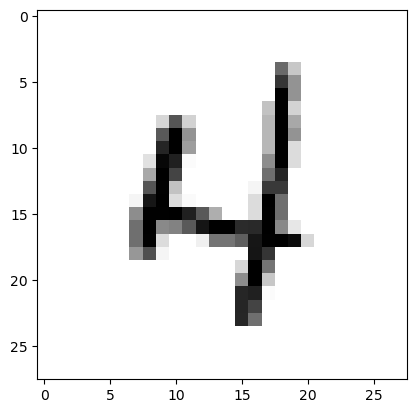

In [8]:

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

# Display an array of random images from dataset


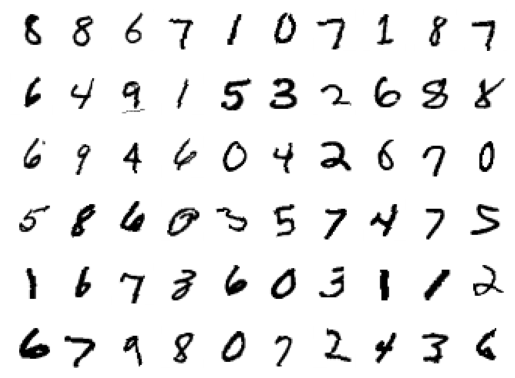

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model Params

Can't emphasize on how important viewing Model Summary is. Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
from model import Net6
use_cuda = torch.cuda.is_available()
device = torch.device(use_cuda if use_cuda else "cpu")
print(device)
model = Net6().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
           Dropout-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 12, 28, 28]             864
       BatchNorm2d-5           [-1, 12, 28, 28]              24
           Dropout-6           [-1, 12, 28, 28]               0
         MaxPool2d-7           [-1, 12, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           1,728
       BatchNorm2d-9           [-1, 16, 14, 14]              32
          Dropout-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 10, 14, 14]           1,440
      BatchNorm2d-12           [-1, 10, 14, 14]              20
          Dropout-13           [-1, 10, 14, 14]               0
        MaxPool2d-14             [-

/Users/vehere/ERA_V2/ERA_v2.0/s7/model.py:186: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Train and test Net6 model

In [12]:
device = torch.device("mps")
model =  Net6().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.15561345219612122 Batch_id=234 Accuracy=88.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 43.59it/s]



Test set: Average loss: 0.0821, Accuracy: 9756/10000 (97.56%)

EPOCH: 1


Loss=0.046751439571380615 Batch_id=234 Accuracy=97.14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 50.99it/s]



Test set: Average loss: 0.0535, Accuracy: 9824/10000 (98.24%)

EPOCH: 2


Loss=0.0857284665107727 Batch_id=234 Accuracy=97.87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 50.47it/s]



Test set: Average loss: 0.0399, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


Loss=0.017410142347216606 Batch_id=234 Accuracy=98.05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 51.50it/s]



Test set: Average loss: 0.0350, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.0805058404803276 Batch_id=234 Accuracy=98.34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 51.15it/s]



Test set: Average loss: 0.0334, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.043122902512550354 Batch_id=234 Accuracy=98.38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 50.20it/s]



Test set: Average loss: 0.0292, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.06225775182247162 Batch_id=234 Accuracy=98.54: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 51.38it/s]



Test set: Average loss: 0.0282, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


Loss=0.06564243137836456 Batch_id=234 Accuracy=98.70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 51.26it/s]



Test set: Average loss: 0.0286, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.04538702219724655 Batch_id=234 Accuracy=98.63: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 51.90it/s]



Test set: Average loss: 0.0269, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.008673095144331455 Batch_id=234 Accuracy=98.72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 49.73it/s]



Test set: Average loss: 0.0231, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.010183986276388168 Batch_id=234 Accuracy=98.83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 51.88it/s]



Test set: Average loss: 0.0263, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.008285846561193466 Batch_id=234 Accuracy=98.82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 51.45it/s]



Test set: Average loss: 0.0276, Accuracy: 9912/10000 (99.12%)

EPOCH: 12


Loss=0.02144310623407364 Batch_id=234 Accuracy=98.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 50.01it/s]



Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.01956089399755001 Batch_id=234 Accuracy=98.94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 49.91it/s]



Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.01681366190314293 Batch_id=234 Accuracy=98.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 51.35it/s]



Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

EPOCH: 15


Loss=0.03325578570365906 Batch_id=234 Accuracy=98.94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 51.95it/s]



Test set: Average loss: 0.0271, Accuracy: 9914/10000 (99.14%)

EPOCH: 16


Loss=0.00420623691752553 Batch_id=234 Accuracy=99.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 51.57it/s]



Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.0579623281955719 Batch_id=234 Accuracy=99.01: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 52.47it/s]



Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.010573463514447212 Batch_id=234 Accuracy=99.07: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 50.90it/s]



Test set: Average loss: 0.0227, Accuracy: 9925/10000 (99.25%)

EPOCH: 19


Loss=0.003993654623627663 Batch_id=234 Accuracy=99.03: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:04<00:00, 52.29it/s]



Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)



# Train Vs Test Loss Plot

In [13]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

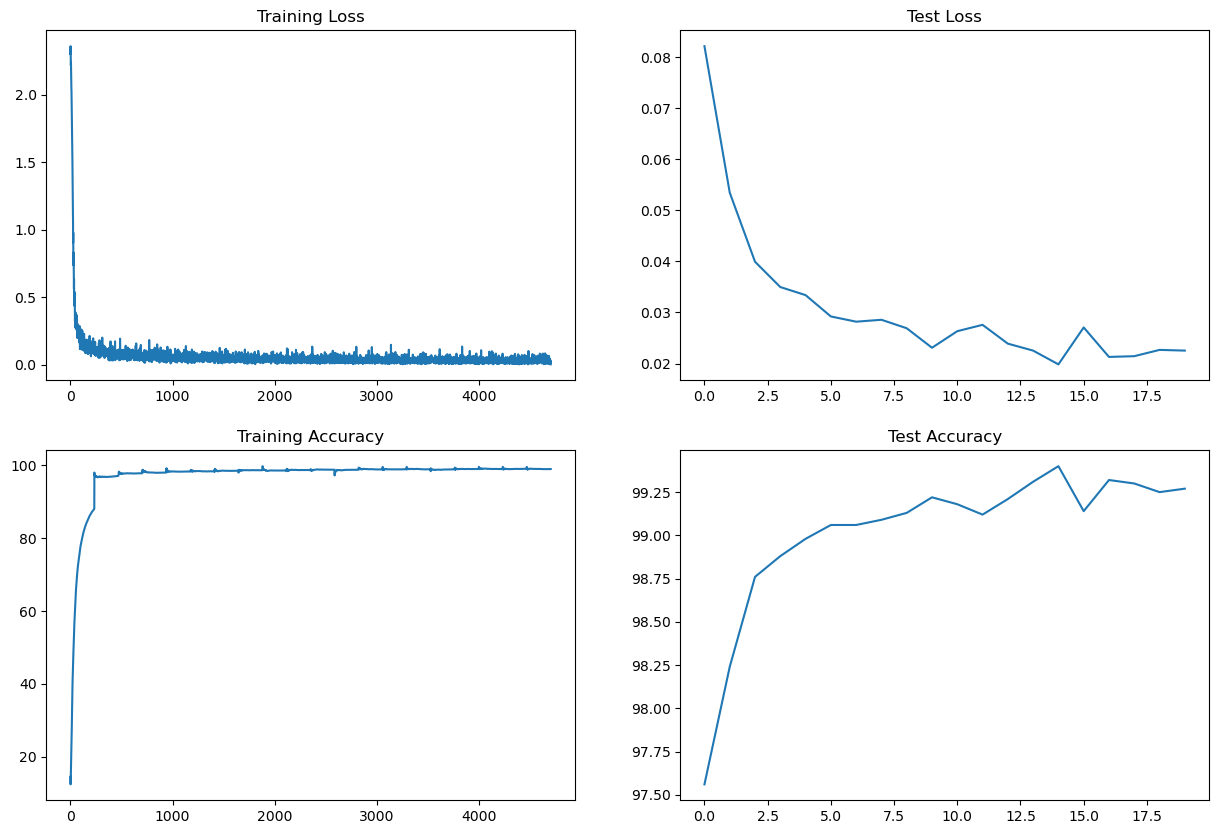

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
* Create light weight model (Net6) with lesser paramerters(<8k). <br>
* Reduce drop out value from 0.2 to 0.1 after every convolution layer. <br>
* Introduce Image Augumentation, such as RandomRotation (Identified from heuristics 5-7% rotation would have provide additional scope for learning) and ColorJitter (Increase in brightness and contrast). <br>

## Results:
* Parameters: 7,664 <br>
* Best Training Accuracy: 98.93 <br>
* Best Test Accuracy: 99.4 <br>
* Total Num of epochs: 14 <br>
## Analysis:
* Net6 is most roubust light weight model created with 7.6k parameters and reached target test accuracy 99.4% at 14th epoch with train accuracy of 98.93. <br>
* This model is not overfitting and there is additional scope for improvement and to boost the test accuracy further. <br>
* Drop out after every convolution layer solved the overfiting problem. <br>
* Image augumentation helped to create a underfitting model with more option to improve the test accuracy with additional training. <br>
